#### different levels of chatbots

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [20]:
llm.invoke("hi").content

'Hi there! How can I help you today?'

In [21]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages

In [22]:
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AnyMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [42]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [43]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

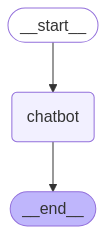

In [44]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [46]:
input={"messages":["hi, my name is pavan"]}


In [47]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is pavan', additional_kwargs={}, response_metadata={}, id='45544e9c-c3e5-4052-af5b-d83ab731d768'),
  AIMessage(content="Hi Pavan, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-2e28ebfc-7c4c-4cd6-ae00-2d3b7d8a9297-0', usage_metadata={'input_tokens': 7, 'output_tokens': 20, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})]}

In [48]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hello Pavan! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-ba26866b-5a0e-4cd5-bb80-9c7b16add34e-0', usage_metadata={'input_tokens': 7, 'output_tokens': 20, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})]}




In [70]:
#add tool

@tool
def search(query: str):
    """this is my custom tool."""
    if "india" not in query.lower():
        return "It's 30 degrees and foggy."
    return "It's 45 degrees and sunny."
    

In [83]:
search.invoke("what is a weather in india?")

"It's 45 degrees and sunny."

In [84]:
tools=[search]
tool_node=ToolNode(tools)

In [85]:
llm_with_tool=llm.bind_tools(tools)

In [86]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [87]:
response=call_model({"messages": ["hi how are you?"]})
response

{'messages': [AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-13ca4fe2-6fc9-428d-a65a-1bf48caa970d-0', usage_metadata={'input_tokens': 16, 'output_tokens': 18, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})]}

In [88]:
messages = response['messages']

In [89]:
last_message=messages[-1]
last_message.tool_calls

[]

In [93]:
response=call_model({"messages": ["what is a climate in India?"]})

In [94]:
messages = response['messages']
messages

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "climate in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-2663981a-540d-440d-9865-4134e778413d-0', tool_calls=[{'name': 'search', 'args': {'query': 'climate in India'}, 'id': '0793d3ee-6cb1-4940-91a4-a930d743e632', 'type': 'tool_call'}], usage_metadata={'input_tokens': 18, 'output_tokens': 5, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})]

In [96]:
last_message=messages[-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'climate in India'},
  'id': '0793d3ee-6cb1-4940-91a4-a930d743e632',
  'type': 'tool_call'}]

In [97]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [98]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

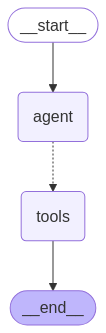

In [99]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [100]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='40d4cba1-3522-4b83-8170-4c8301d9b56e'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-2f03605f-75cd-4cb2-bfa4-bbedb7303ad6-0', usage_metadata={'input_tokens': 16, 'output_tokens': 18, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})]}

In [101]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='3bd703e3-05dd-4769-97bc-507c999d6165'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-9bccd5ba-74bb-4d6a-80a0-9389d58e2bda-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'd2dab37b-2948-40a2-98f5-8faea980cc53', 'type': 'tool_call'}], usage_metadata={'input_tokens': 17, 'output_tokens': 5, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 30 degrees and foggy.", name='search', id='e0d746f1-2447-4a80-898c-e686f4e76baf', tool_call_id='d2dab37b-2948-40a2-98f5-8faea980cc53')]}

In [102]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [103]:
app = workflow.compile()

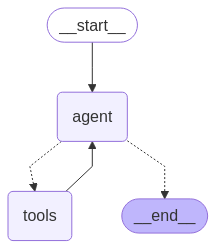

In [104]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [106]:
for output in app.stream({"messages": ["what is the weather in india"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in india"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-a205b9f8-a4b8-46b7-bde3-73047635f7ad-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in india'}, 'id': '42bfffee-b3d6-4042-953a-d39bc25ef810', 'type': 'tool_call'}], usage_metadata={'input_tokens': 17, 'output_tokens': 5, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 45 degrees and sunny.", name='search', id='5d01aa0a-8448-4252-bb26-f69df73a1f0e', tool_call_id='42bfffee-b3d6-4042-953a-d39bc25ef810')]}


here is output from agent
_______
{'messages': [AIMessage(content='It is 45 degrees and sunny in India.', additional_kwargs={}, response_met

In [107]:
## Memory

In [108]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [109]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [110]:
app3 = workflow3.compile(checkpointer = memory)

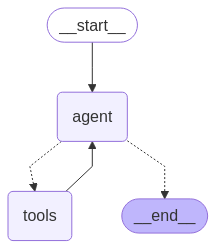

In [111]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [112]:
config = {"configurable": {"thread_id": "abc"}}

In [113]:
events = app3.stream(
    {"messages": ["Hi there! My name is pavan."]}, config, stream_mode="values"
)

In [114]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is pavan.
================================== Ai Message ==================================

Hi Pavan, nice to meet you! How can I help you today?


In [129]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [130]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised DeadlineExceeded: 504 Deadline Exceeded.


================================== Ai Message ==================================

Your name is Pavan.


In [117]:
memory.get(config)

{'v': 3,
 'ts': '2025-04-30T12:37:21.853826+00:00',
 'id': '1f025bfd-c99d-6fe7-8004-c766ce5c858b',
 'channel_versions': {'__start__': '00000000000000000000000000000005.0.7495742755643298',
  'messages': '00000000000000000000000000000006.0.36345341388314156',
  'branch:to:agent': '00000000000000000000000000000006.0.9952067572335066'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000004.0.3504084375435793'},
  'agent': {'branch:to:agent': '00000000000000000000000000000005.0.63518679177706'}},
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is pavan.', additional_kwargs={}, response_metadata={}, id='4cec03ab-4e54-42a9-9a02-cf1afc74bc5a'),
   AIMessage(content='Hi Pavan, nice to meet you! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-5ddcb9d1-180c

In [118]:
events

<generator object Pregel.stream at 0x76b7c41d11c0>

In [131]:
for event in events:
    print("f")
    # print(event["messages"].pretty_print())
    for i in event['messages']:
        print("1")
        i.pretty_print()